In [111]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [112]:
from database import FinanceDB
from utils import money

db = FinanceDB()
financas = db.get_financas()
accounts = db.get_accounts()

In [113]:
def get_totals(df, accounts, log=True):
    inicial_balance = accounts["saldo_inicial"].sum()
    total_entrada = df[df["tipo"] == "Recebimento"]["valor"].sum()
    total_saida = -df[df["tipo"] == "Gasto"]["valor"].sum()
    total_transferencias = -df[df["tipo"] == "Transferência"]["valor"].sum()

    saldo = total_entrada - total_saida - total_transferencias + inicial_balance

    if log:
        print(f"Total Entrada: {money(total_entrada)}")
        print(f"Total Saída: {money(total_saida)}")
        print(f"Total Transferências: {money(total_transferencias)}")
        print(f"Saldo: {money(saldo)}")
        
    return total_entrada, total_saida, total_transferencias, saldo

In [114]:
def get_summary(df, period:str='M'):
    period = period.upper()
    types = {'Y':'ano', 'M': 'mes', 'W': 'semana', 'D': 'dia'}
    if period not in types:
        raise ValueError(f"Período inválido: {period}. Use  'Y' para anual, 'M' para mensal, 'W' para semanal ou 'D' para diário.")
    
    df[types[period]] = df["data"].dt.to_period(period)
    summary = df.groupby([types[period], "tipo"])["valor"].sum().unstack().fillna(0)
    summary.drop(columns=["Transferência"], inplace=True, errors='ignore')
    summary = summary[["Recebimento", "Gasto"]]
    summary["saldo"] = summary.get("Recebimento", 0) + summary.get("Gasto", 0)
    return summary

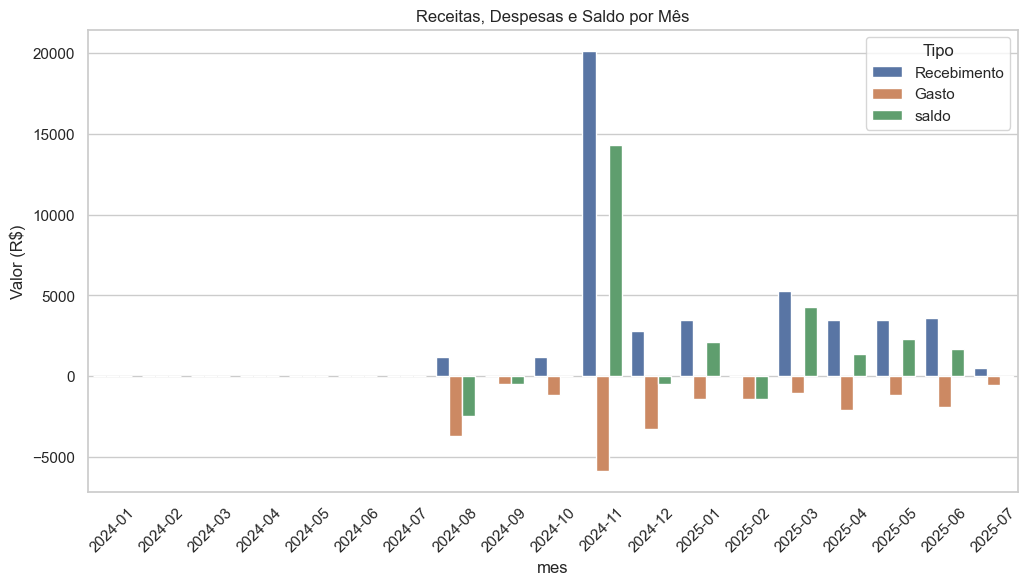

In [115]:
resumo_mensal = get_summary(financas)
resumo_mensal.reset_index(inplace=True)
resumo_plot = pd.melt(resumo_mensal, id_vars="mes", value_vars=["Recebimento", "Gasto", "saldo"],
                      var_name="Tipo", value_name="Valor")

sns.barplot(data=resumo_plot, x="mes", y="Valor", hue="Tipo")
plt.xticks(rotation=45)
plt.title("Receitas, Despesas e Saldo por Mês")
plt.ylabel("Valor (R$)")
plt.show()

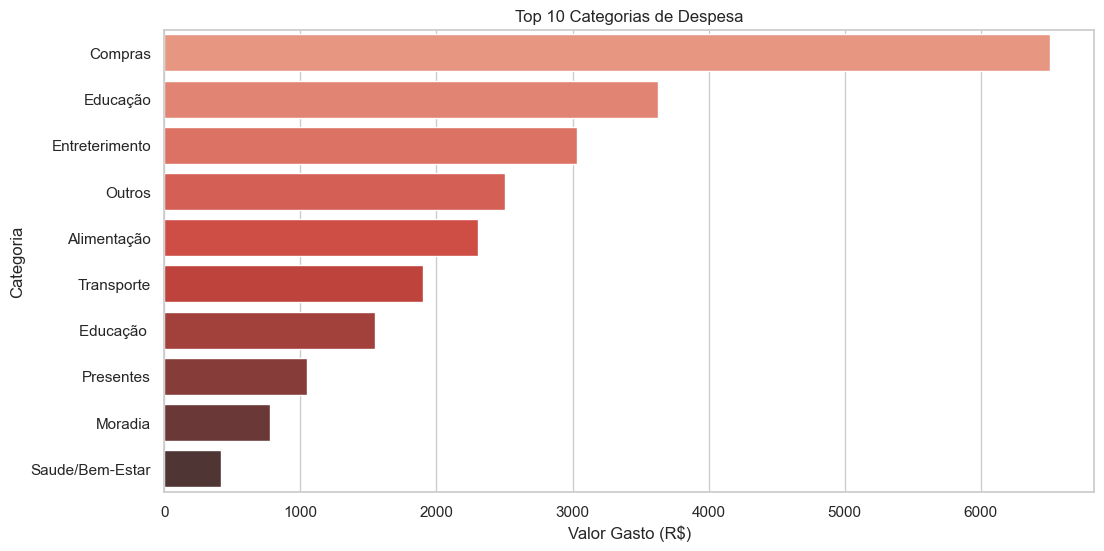

In [116]:
df_despesas = financas[financas["tipo"] == "Gasto"]
categorias = (
    df_despesas.groupby("categoria")["valor"]
    .sum()
    .sort_values(ascending=True)
    .head(10)
)

sns.barplot(x=-categorias.values, y=categorias.index, palette="Reds_d", hue=categorias.index, legend=False)
plt.title("Top 10 Categorias de Despesa")
plt.xlabel("Valor Gasto (R$)")
plt.ylabel("Categoria")
plt.show()


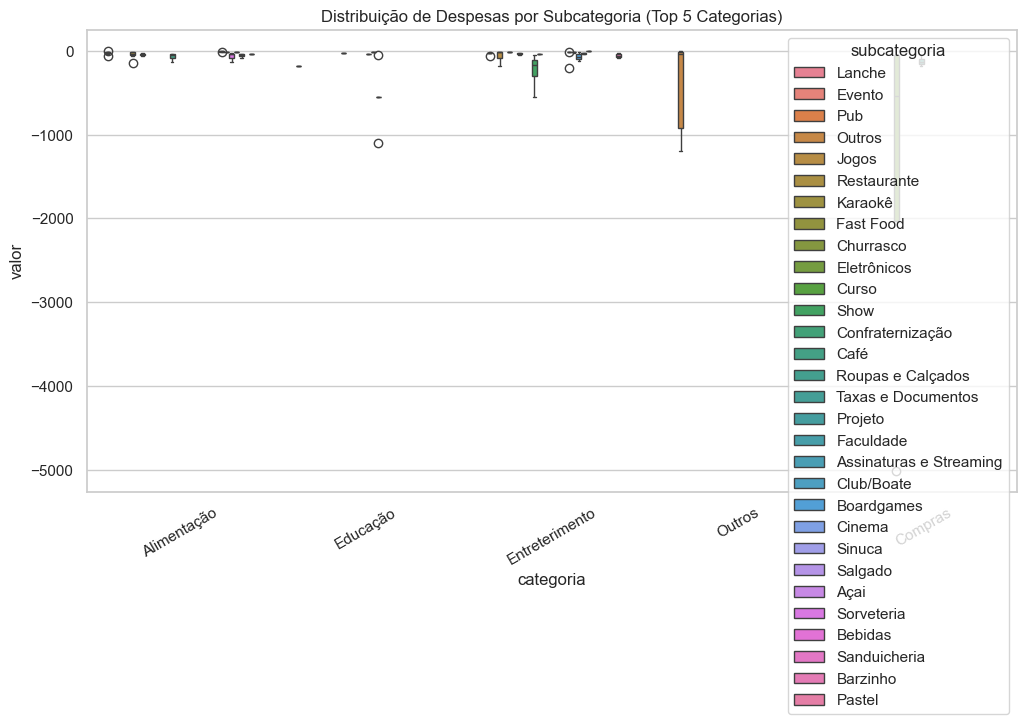

In [117]:
top5_categorias = categorias.head(5).index.tolist()
df_topcat = df_despesas[df_despesas["categoria"].isin(top5_categorias)]

sns.boxplot(data=df_topcat, x="categoria", y="valor", hue="subcategoria")
plt.xticks(rotation=30)
plt.title("Distribuição de Despesas por Subcategoria (Top 5 Categorias)")
plt.show()

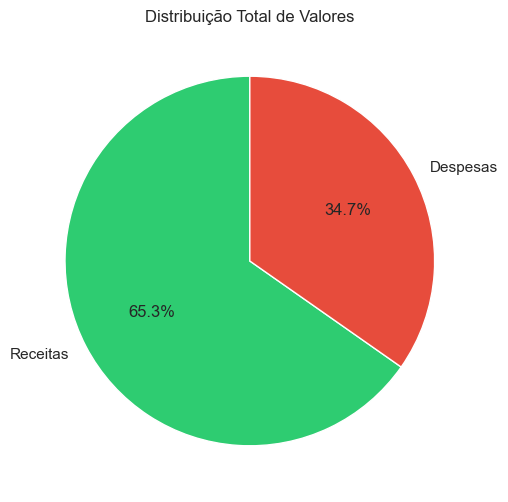

In [118]:
proporcao = financas.groupby("tipo")["valor"].sum()
proporcao = proporcao.reindex(["Recebimento", "Gasto"], fill_value=0)
proporcao["Gasto"] = -proporcao.get("Gasto", 0)
proporcao.plot.pie(autopct="%.1f%%", startangle=90, colors=["#2ecc71", "#e74c3c"], labels=["Receitas", "Despesas"])
plt.title("Distribuição Total de Valores")
plt.ylabel("")
plt.show()
